##  A Brief writeup of feature engineering, selection process and model
>

In [181]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
#%matplotlib inline

In [182]:
# return position index of key found in line
def location_of_key(key, line):
    lst_of_words = line.split(' ')
    npos = 0
    for x in lst_of_words:
        if key not in str(x):
            npos += 1
        else:
            return npos

    return None

In [183]:
# return bool flag for a found key in a line
def result_with_reverse_keyword(key, npos, line):
    lst_of_words = line.split(' ')
    npos01 = 0
    for x in lst_of_words:
        if key not in str(x):
            npos01 += 1
        else:
            break
            
    if npos01 < npos:
        return True
    else:
        return False

In [184]:
# return tot number of occurrences item in list words found in line 
def count_occurrences(words, line):
    noccur = 0
    for w in words:
        noccur += str(line).lower().count(w.lower())
    return noccur

## Use Dataset  yelp_labelled.txt


In [185]:
# use Dataset 
df = pd.read_csv('../data-101/sentiment_labelled_sentences/yelp_labelled.txt', delimiter='\t', header=None)
df.columns = ['message', 'rating']

## Feature Engineering, 

    Below are Several steps used to perform feature engineering:
    
    1) Construct four keyword lists, which contain the crucial keywords indicating positive or negative feelings.
        1.a) 'good' list
        1.b) 'bad' list
        1.c) 'negate' list
        1.d) 'enforce' list
        
    2) The logic of setting values:
        2.a) If any word contained in 'negate' list, the result = False
        2.b) Else, count all words in 'good' list as n_good, all words in 'bad' list as n_bad
                   count all words in 'enforce' list as n_enforce
                   if (n_good - n_bad) > 0: the result = True
                   elif (n_good - n_bad) < 0: the result = False
                   else:                      the result = False

In [186]:
keywords_good = ['best', 'great', 'wonderful', 'delicious', 'fantastic', 'perfect', 'amazing', 
                 'tasty', 'good', 'love', 'nice', 'like', 'prompt', 'inexpensive', 'refreshing', 
                 'happier', 'happy', 'tender', 'friendly', 'fresh', 'recommend', 'impress', 
                 'beautiful', 'delight', 'tasty', 'huge', 'glad', 'yummy', 'mmm', 'phenomenal', 
                 'solid', 'clean', 'decorated', 'excellent', 'immediate', 'modern', 'coziness', 
                 'incredible', 'tasty', 'bargain', 'welcome', 'special', 'flavorful', 'fast', 
                 'exquisite', 'outstanding', 'delish']

keywords_bad = ['poor', 'gross', 'hard', 'worst', 'bad', 'overpriced', 'disappoint', 'overwhelmed', 
                'disgusted', 'shocked', 'slow', 'luke', 'horrible', 'suck', 'appalling', 'cheated', 
                'bland', 'wait', 'mediocre', 'rude', 'down', 'sad', 'insult', 'disrespect', 'waiting', 
                'lacking', 'uninspire', 'wrong', 'boring']

keywords_negate = ['no', 'not', 'don\'t', 'didn\'t', 'wouldn\'t', 'aren\'t', 'isn\'t', 'wasn\'t', 
                   'weren\'t', 'can\'t', 'couldn\'t', 'won\'t', 'shouldn\'t', 'haven\'t', 'hadn\'t', 
                   'damn', 'never', 'nothing']

keywords_enforce = ['so', 'really', 'very', 'back', 'again', 'worth', 'recommend', 'next', 'quite']


In [187]:
additional_columns = ['good', 'bad', 'negate', 'enforce', 'combine']
df['rating'] = (df['rating'] == 1)
for col in additional_columns:
    df[str(col)] = 0

In [188]:
# feature engineering, getting 'good' list & 'bad' list & 'negate' list & 'enforce' list
good_lst = list(map(lambda x: count_occurrences(keywords_good, x), df['message'].tolist()))
bad_lst = list(map(lambda x: count_occurrences(keywords_bad, x), df['message'].tolist()))
negate_lst = list(map(lambda x: count_occurrences(keywords_negate, x), df['message'].tolist()))
enforce_lst = list(map(lambda x: count_occurrences(keywords_enforce, x), df['message'].tolist()))
df['good'] = list(map(lambda x: x > 0, good_lst))
df['bad'] = list(map(lambda x: x > 0, bad_lst))
df['negate'] = list(map(lambda x: x > 0, negate_lst))
df['enforce'] = list(map(lambda x: x > 0, enforce_lst))

combine_lst = []
for iter in range(len(good_lst)):
    x_n = negate_lst[iter]
    x_g = good_lst[iter]
    x_b = bad_lst[iter]
    x_e = enforce_lst[iter]
    if x_n > 0:
        combine_lst.append(False)
    else:
        if x_g > x_b:
            combine_lst.append(True)
        elif x_g < x_b:
            combine_lst.append(False)
        else:
            if x_e > 0:
                combine_lst.append(True)
            else:
                combine_lst.append(False)

df['combine'] = combine_lst

In [189]:
df.head()

,message,rating,good,bad,negate,enforce,combine
0,Wow... Loved this place.,True,True,False,False,False,True
1,Crust is not good.,False,True,False,True,False,False
2,Not tasty and the texture was just nasty.,False,True,False,True,False,False
3,Stopped by during the late May bank holiday of...,True,True,False,False,True,True
4,The selection on the menu was great and so wer...,True,True,False,False,True,True


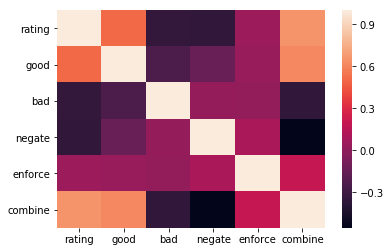

In [190]:
sns.heatmap(df.corr())

## heatmap shows good correlation between combine flag and expected rating flag, and 
## independence between each other for rest of variables. 

## The model is a naive bayes model, with individual probability of Bernoulli distribution.

In [191]:
data = df[['good', 'bad', 'negate', 'enforce', 'combine']]
target = df['rating']

In [192]:
model = BernoulliNB()
model.fit(data, target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [193]:
# predicted classification
y_pred = model.predict(data)
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 176


In [194]:
a = (1000 - 176) / 1000
print('accuracy = {}'.format(a))

accuracy = 0.824


In [195]:
from sklearn.metrics import confusion_matrix

In [196]:
confusion_matrix(target, y_pred)

array([[451,  49],
       [127, 373]], dtype=int64)